In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load the dataset
file_path = r"locations_updated.csv"
data = pd.read_csv(file_path)

# Feature Engineering

data['Room_to_Bathroom_Ratio'] = data['Bedrooms'] / data['Bathrooms']
data['Room_to_Bathroom_Ratio'] = data['Room_to_Bathroom_Ratio'].replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=['Room_to_Bathroom_Ratio'])

data['Price_per_m2'] = data['Price'] / data['Area (m²)']

# Handle outliers using IQR
q1 = data['Price'].quantile(0.25)
q3 = data['Price'].quantile(0.75)
iqr = q3 - q1
outliers = (data['Price'] < (q1 - 1.5 * iqr)) | (data['Price'] > (q3 + 1.5 * iqr))
data = data[~outliers]

# Encode categorical features
label_encoder = LabelEncoder()
data['Property Type'] = label_encoder.fit_transform(data['Property Type'])
data['Governorate'] = label_encoder.fit_transform(data['Governorate'])
data['Location'] = label_encoder.fit_transform(data['Location'])

# Define Features and Target
X = data.drop(columns=['Price'])
y = data['Price']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],     
    'max_depth': [3, 5, 7],              
    'learning_rate': [0.01, 0.05, 0.1],   
    'subsample': [0.8, 1.0],              
    'colsample_bytree': [0.8, 1.0]       
}

grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse):.2f}")
print(f"R² Score: {r2:.4f}")


XGBoost Model Performance Metrics:
Mean Absolute Error (MAE): 19.12
Mean Squared Error (MSE): 1599.47
Root Mean Squared Error (RMSE): 39.99
R² Score: 0.9959


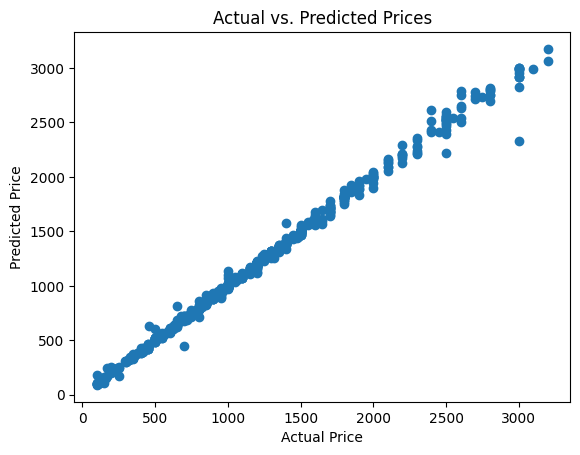

In [2]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")
plt.show()